# Homework 2
Richy Peterson  
DASC 522 Machine Learning

_1. Data: The “LRS_Pre_Assessment_trimmed_rank.csv” physical fitness testing dataset is provided for use in this exercise. The data was collected from an active-duty squadron and the samples were deidentified at the point of collection._   

   _a. The independent variables include numeric and categorical data related to demographics, mental health surveys, fitness participation surveys, injury history surveys, physical performance measures, and body composition assessments._  
    
   _b. The dependent variable is whether or not the member passed their fitness test, and is titled APFT_1_is_pass.  For this label, pass = 1, and fail = 0._

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score


_2. Modeling: In a marked-up Jupyter notebook (*.ipynb):_
    
   _a. Break your code into logical chunks, using multiple “text” and “code” sections, similar to the examples given in class._

# Data Understanding and Preparation

Load Data

In [2]:
df = pd.read_csv('LRS_Pre_Assessment_trimmed_rank.csv')
df.head()

,Flight,Rank,Age,Gender,ORS_total,PTSD_score,Sleep_score,survey_Burnout,survey_FitSat,BMI,BodyFatPerc,MusclePerc,APFT_1_is_pass
0,D,JrEnlisted,40,M,9.8,5,8,2,3,27.9,0.3000,0.328,1
1,D,JrEnlisted,22,M,5.0,22,10,4,2,33.0,0.3680,0.308,0
2,D,JrEnlisted,20,M,9.6,1,3,1,3,24.8,0.0273,0.356,0
3,M,JrEnlisted,21,F,5.0,12,13,5,3,24.5,0.4160,0.221,1
4,D,JrEnlisted,27,M,8.3,0,6,1,5,23.7,0.2120,0.385,1


_2.b. Drop the “flight” column and one-hot-encode the “rank” & “gender” columns with df_ohe = pd.get_dummies(df, drop_first=True). drop_first is needed so the columns are linearly independent._

In [3]:
df_ohe = pd.get_dummies(df.drop('Flight', axis=1), drop_first=True, dtype=int)
df_ohe.head()

,Age,ORS_total,PTSD_score,Sleep_score,survey_Burnout,survey_FitSat,BMI,BodyFatPerc,MusclePerc,APFT_1_is_pass,Rank_SrEnlisted,Rank_officer,Gender_M
0,40,9.8,5,8,2,3,27.9,0.3000,0.328,1,0,0,1
1,22,5.0,22,10,4,2,33.0,0.3680,0.308,0,0,0,1
2,20,9.6,1,3,1,3,24.8,0.0273,0.356,0,0,0,1
3,21,5.0,12,13,5,3,24.5,0.4160,0.221,1,0,0,0
4,27,8.3,0,6,1,5,23.7,0.2120,0.385,1,0,0,1


### Data Understanding information and visuals

_2.c. Create a Data Understanding table using .describe() and include 3 Data Understanding visualizations such as a scatterplot, histogram, pairplot or correlation matrix._

In [4]:
# Create a Data Understanding table using .describe() and include 3 Data Understanding visualizations such as a scatterplot, histogram, pairplot or correlation matrix.
df_ohe.describe()

,Age,ORS_total,PTSD_score,Sleep_score,survey_Burnout,survey_FitSat,BMI,BodyFatPerc,MusclePerc,APFT_1_is_pass,Rank_SrEnlisted,Rank_officer,Gender_M
count,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000,157.000000
mean,27.942675,7.620382,9.312102,7.305732,2.140127,3.331210,27.110191,0.294873,0.327968,0.707006,0.509554,0.038217,0.757962
std,6.164666,1.955621,11.795182,3.939710,0.812235,0.803746,4.093791,0.086974,0.060547,0.456592,0.501508,0.192332,0.429688
min,19.000000,0.200000,0.000000,0.000000,1.000000,1.000000,18.400000,0.014700,0.036500,0.000000,0.000000,0.000000,0.000000
25%,23.000000,6.700000,1.000000,4.000000,2.000000,3.000000,24.400000,0.248000,0.289000,0.000000,0.000000,0.000000,1.000000
50%,26.000000,8.000000,5.000000,7.000000,2.000000,3.000000,27.100000,0.296000,0.334000,1.000000,1.000000,0.000000,1.000000
75%,33.000000,9.000000,12.000000,10.000000,2.000000,4.000000,29.700000,0.346000,0.366000,1.000000,1.000000,0.000000,1.000000
max,45.000000,10.000000,68.000000,22.000000,5.000000,5.000000,38.300000,0.495000,0.473000,1.000000,1.000000,1.000000,1.000000


In [5]:
# move the dependent variable to the last column. The code below was modified from code found on stack overflow to move columns: https://stackoverflow.com/questions/35321812/move-column-in-pandas-dataframe
target = 'APFT_1_is_pass'
df_ohe.insert(len(df_ohe.columns)-1, target, df_ohe.pop(target))

In [76]:
df_ohe['APFT_1_is_pass'].value_counts()

APFT_1_is_pass
1    111
0     46
Name: count, dtype: int64

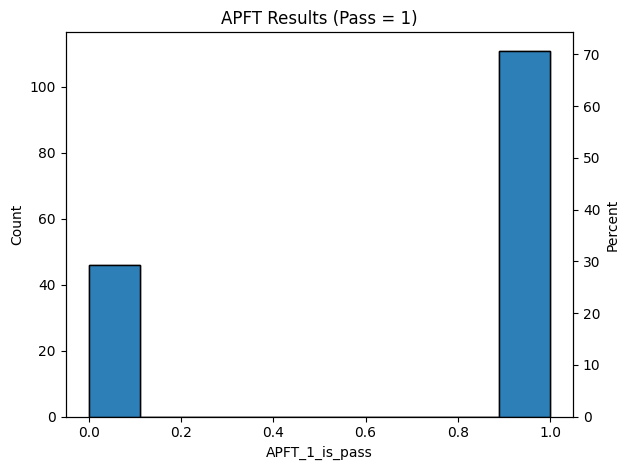

In [66]:
fig, ax = plt.subplots()
sns.histplot(data=df_ohe, x=target, ax=ax)
ax2 = ax.twinx()
sns.histplot(data=df_ohe, x=target, ax=ax2, stat='percent')
ax.set_title('APFT Results (Pass = 1)')
fig.tight_layout()
# Used https://stackoverflow.com/questions/60711893/seaborn-displot-with-two-y-axes to figure out how to plot a second axes

Over twice as many tests were passed than failed. The AFPT was passed approximately 70.7% of the time for the given dataset.

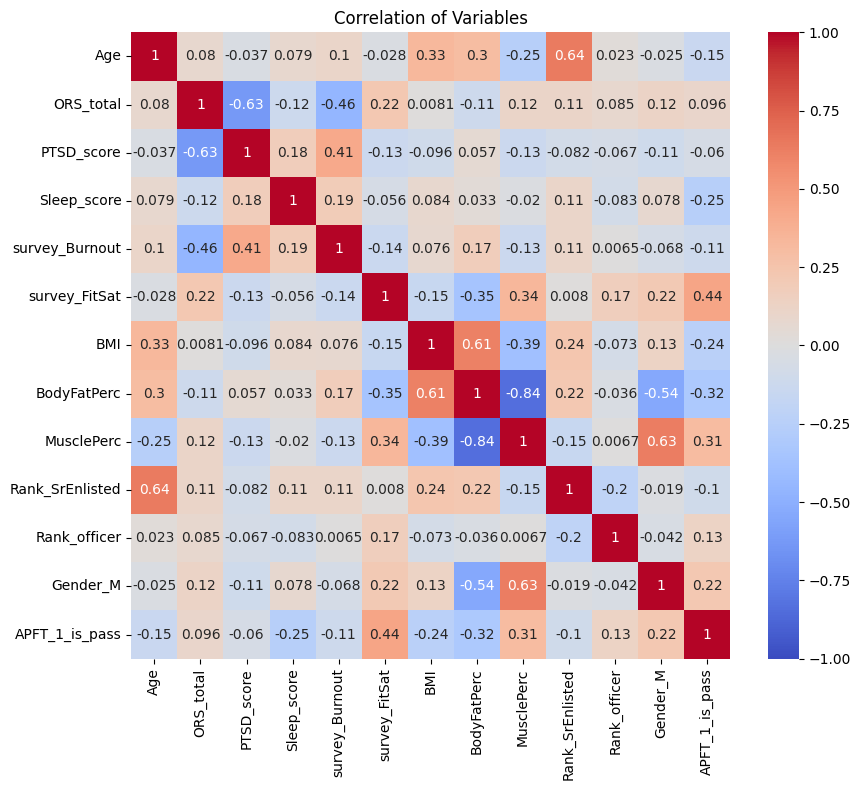

In [7]:
fig, ax = plt.subplots(figsize=(9,8))
sns.heatmap(df_ohe.corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
ax.set_title('Correlation of Variables')
fig.tight_layout()

survey_FitSat has the highest correlation to passing the fitness assessment, followed by BodyFatPerc (negative) and MusclePerc.  
Not surprisingly BodyFatPerc and MusclePerc are highly correlated, as well as BodyFatPerc and BMI. Gender also has a relatively high correlation with BodyFatPerc and MusclePerc.

C:\Users\elder\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\elder\AppData\Local\Temp\ipykernel_12148\2047342475.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


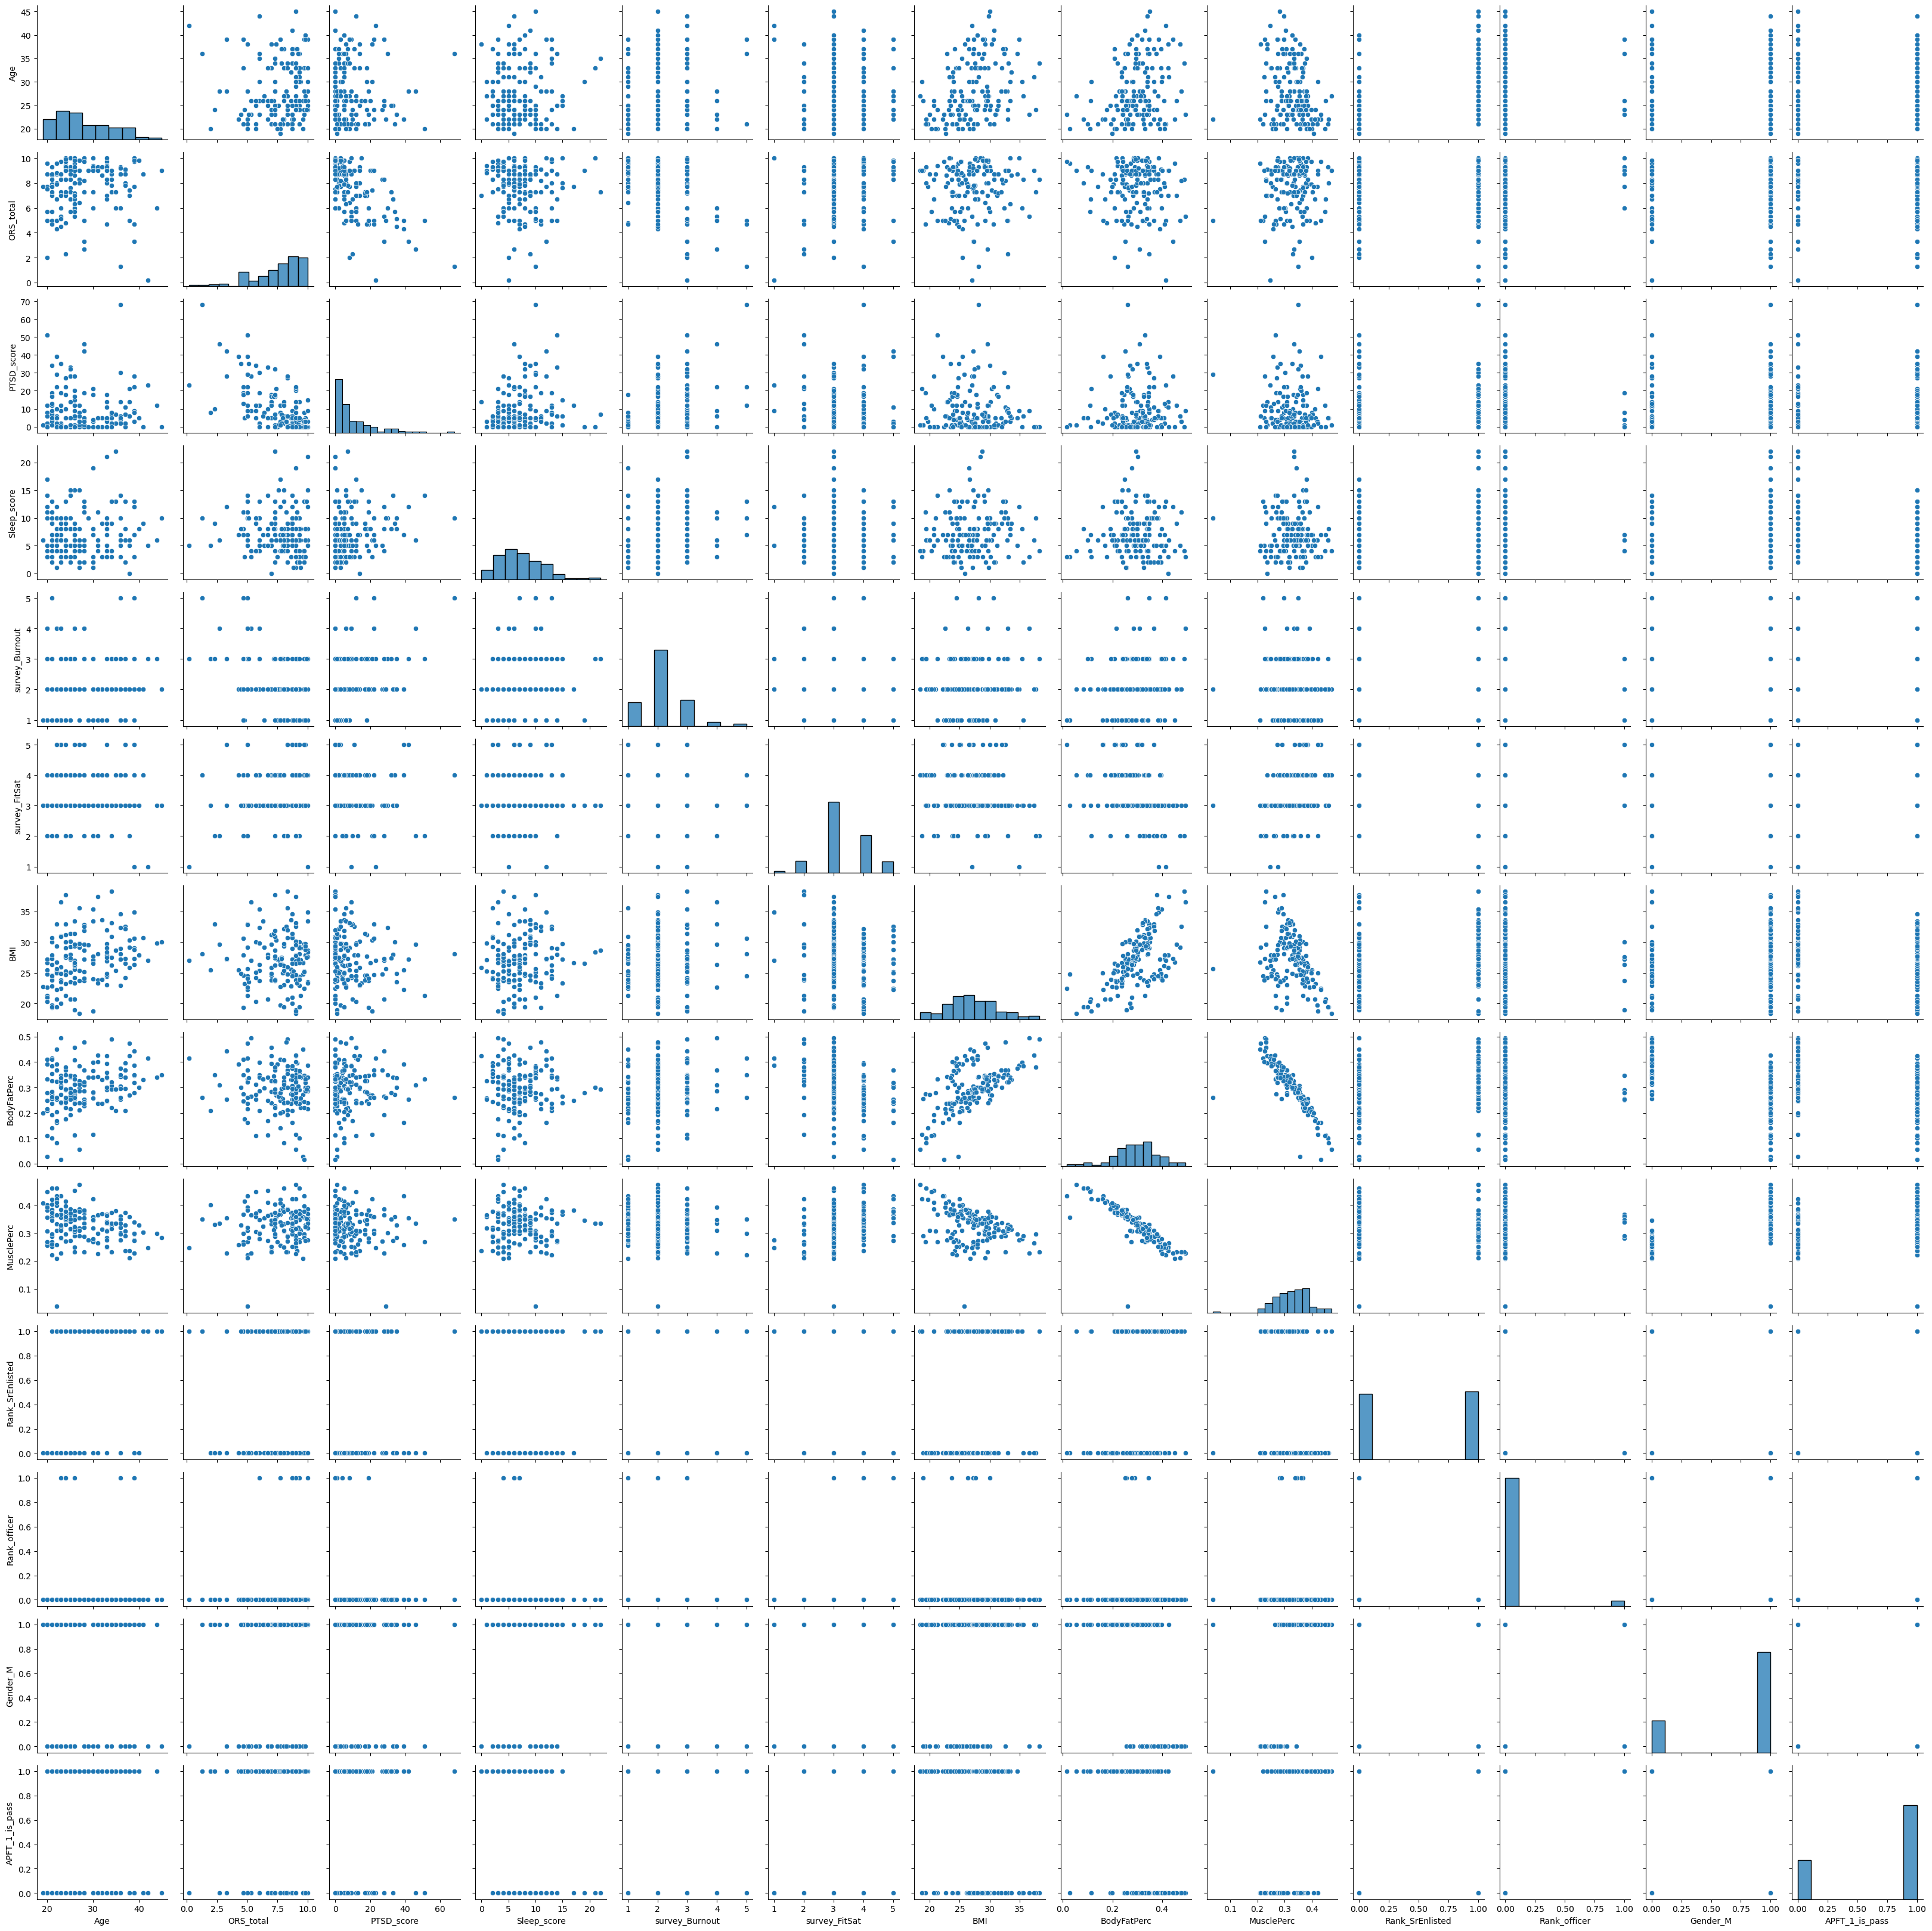

In [22]:
sns.pairplot(df_ohe)
plt.show()

Observations from pairplot:  
Scatterplot portions support the correlation matrix comments.  
Histograms:  
ORS_total and PTSD_score are not normaly distributed, others look normalish with skewness and kertosis.   
The data is predomonately (>95%) from enlisted personnel. Approximately 80% of data is from males.

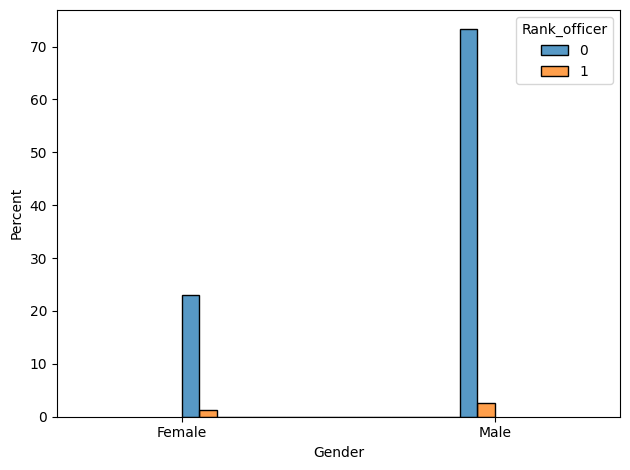

In [59]:
fig, ax = plt.subplots()
sns.histplot(data=df_ohe, x='Gender_M', hue='Rank_officer', stat='percent', multiple='dodge',ax=ax)
ax.set_xlim(-.4,1.4)
ax.set_xticks([0,1],labels=['Female','Male'])
ax.set_xlabel('Gender')
fig.tight_layout()

Approximately 75% of data is from enlisted males.

# Model Development
## Model 1

_2.d. Split df_ohe into 70% train & 30% test_

In [8]:
# split the data in X and y and training and testing
X = df_ohe.loc[:, df_ohe.columns != 'APFT_1_is_pass']
y = df_ohe.loc[:, df_ohe.columns == 'APFT_1_is_pass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=49)

_2.e. Model #1: Train a statsmodels sm.Logit algorithm on the train dataset._

In [9]:
model1 = sm.Logit(y_train, X_train).fit()
print(model1.summary())

         Current function value: 0.361460
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:         APFT_1_is_pass   No. Observations:                  109
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                           11
Date:                Thu, 19 Oct 2023   Pseudo R-squ.:                  0.3857
Time:                        08:16:19   Log-Likelihood:                -39.399
converged:                      False   LL-Null:                       -64.135
Covariance Type:            nonrobust   LLR p-value:                 7.790e-07
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Age                 0.0096      0.071      0.135      0.893      -0.130       0.149
ORS_total          -0.0850      0.205     -0.415  

C:\Users\richard.peterson\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Transform Features

_2.f. Create a copy of the dataframe using df_xform = df_ohe.copy(deep=True)_

In [10]:
df_xform = df_ohe.copy(deep=True)

_2.g. On df_xform, perform a box-cox transform on the Age and ORS_total features, and a yeo-johnson transform on the PTSD_score feature. Refer to the week 3 “DASC 522 guide to feature standardization & transformation” for assistance._

In [11]:
# functions to transform features and compare 
def transform_feature(df,col_name,trans_method):
    from sklearn.preprocessing import PowerTransformer
    pow_trans = PowerTransformer(method=trans_method)
    col_to_trans = df[[col_name]]
    pow_trans.fit(col_to_trans)
    return pow_trans.transform(col_to_trans)

def plot_transform_compare(df,df_xform,col_name):
    fig, (ax1,ax2) = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
    sns.histplot(data=df, x=col_name, ax=ax1)
    sns.histplot(data=df_xform, x=col_name, ax=ax2)
    ax1.set_title(f'{col_name} Untransformed')
    ax2.set_title(f'{col_name} Transformed')
    fig.tight_layout()

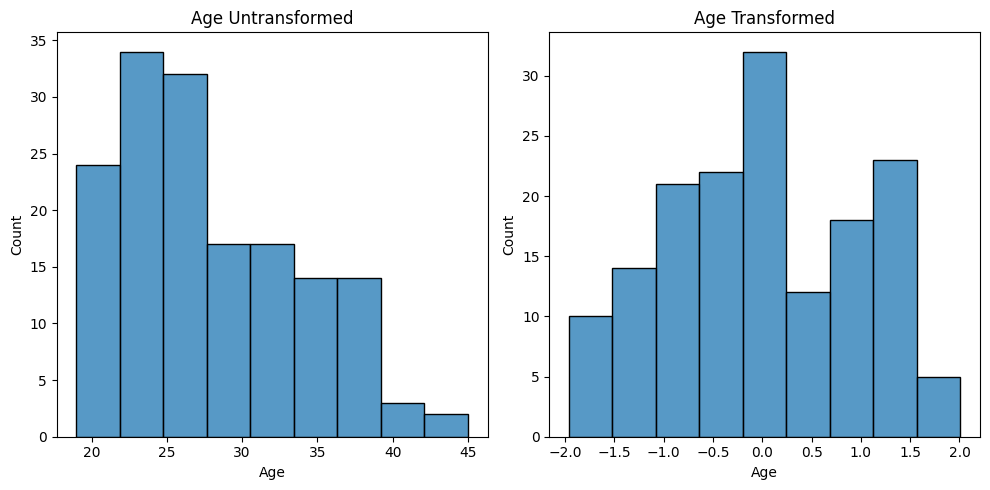

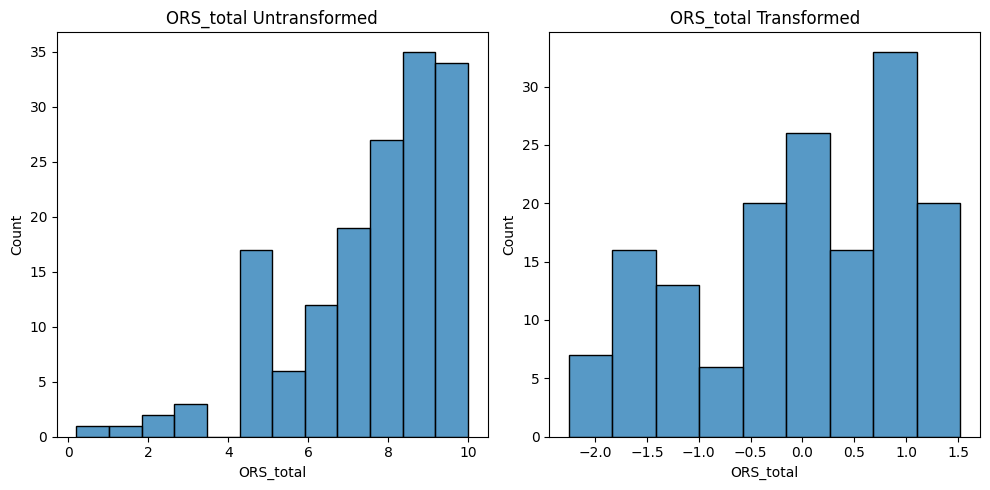

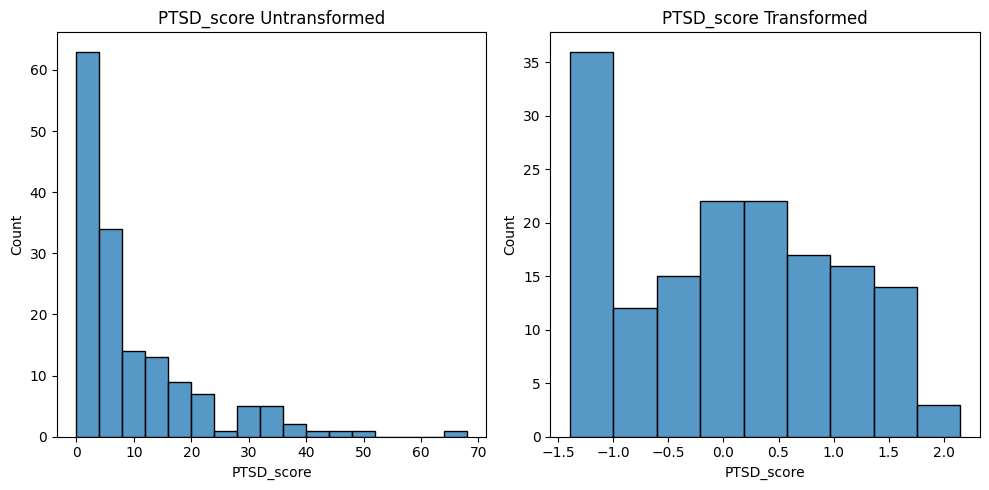

In [12]:
df_xform['Age'] = transform_feature(df_xform,'Age','box-cox')
plot_transform_compare(df_ohe,df_xform,'Age')

df_xform['ORS_total'] = transform_feature(df_xform,'ORS_total','box-cox')
plot_transform_compare(df_ohe,df_xform,'ORS_total')

df_xform['PTSD_score'] = transform_feature(df_xform,'PTSD_score','yeo-johnson')
plot_transform_compare(df_ohe,df_xform,'PTSD_score')

## Standardize Features

_2.h. On df_xform, standardize the following features using StandardScaler():_

    i. Sleep_score
    ii. survey_Burnout	
    iii. survey_FitSat	
    iv. BMI	
    v. BodyFatPerc	
    vi. MusclePerc


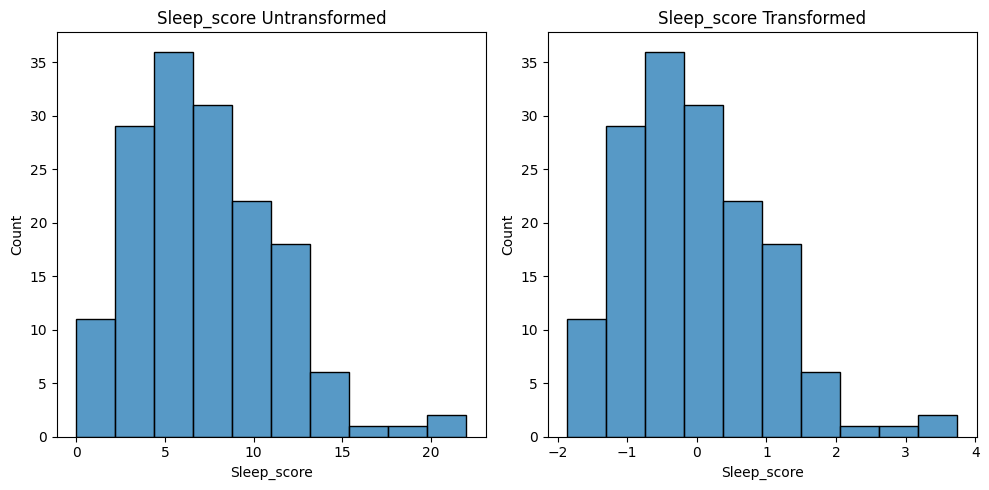

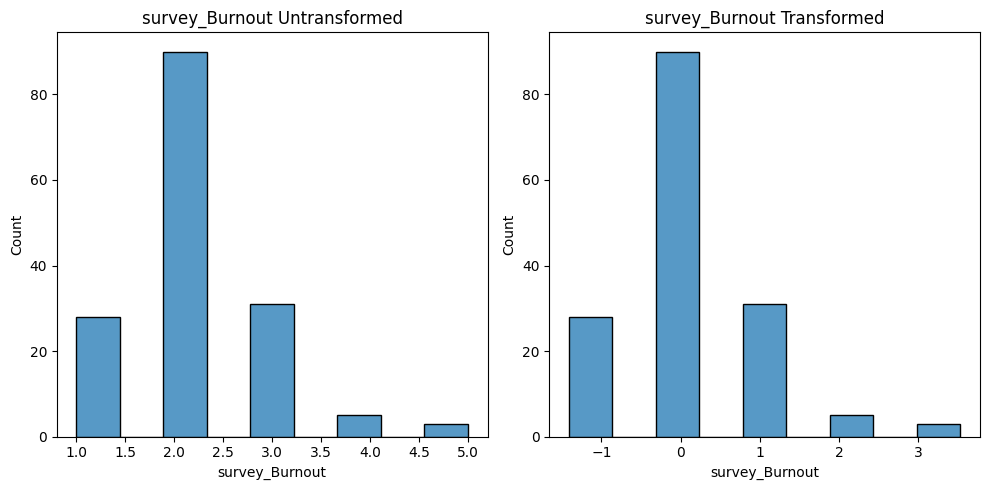

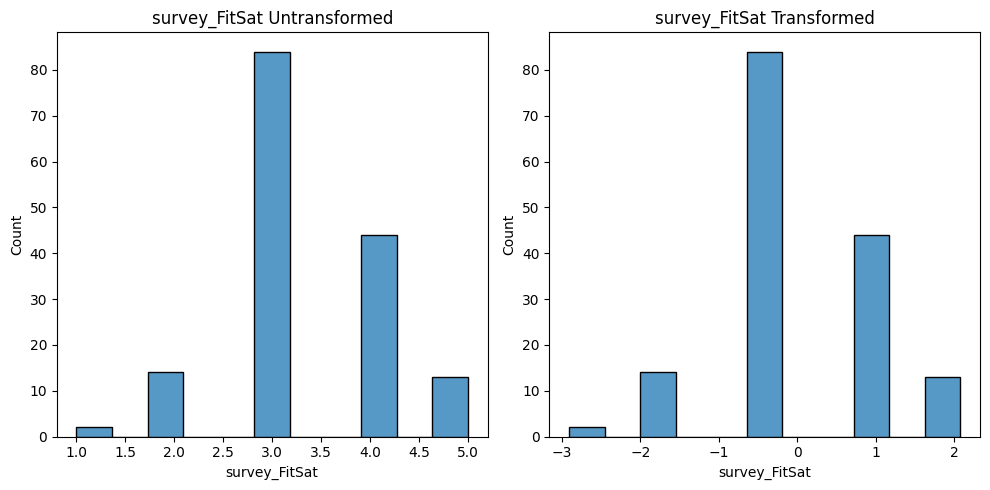

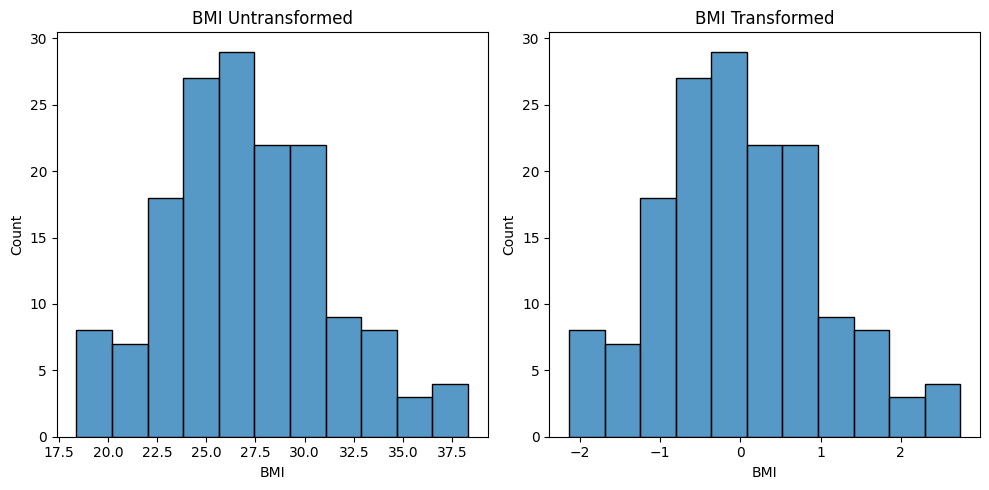

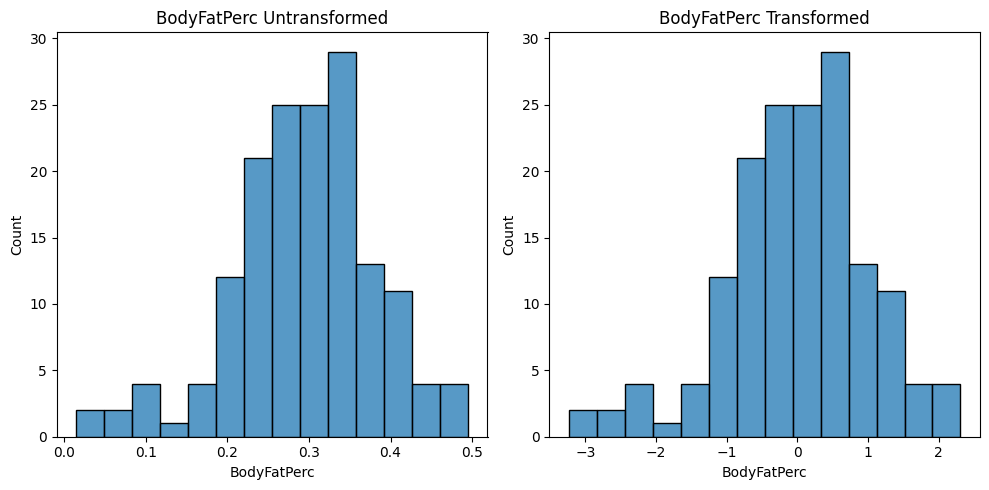

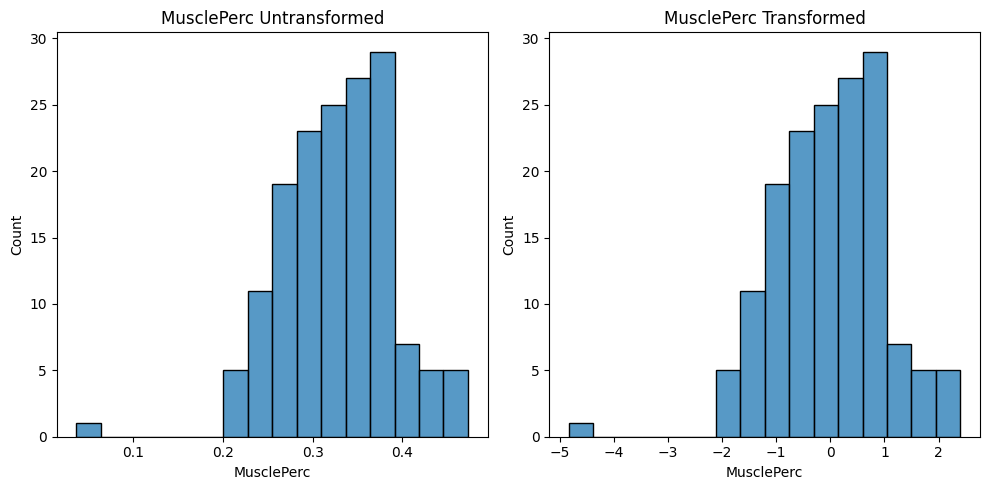

In [13]:
# standardize features to have mean of zero and standard deviation of 1
scaler = StandardScaler()
for col in ['Sleep_score','survey_Burnout','survey_FitSat','BMI','BodyFatPerc','MusclePerc']:
    df_xform[col] = scaler.fit_transform(df_xform[[col]])
    plot_transform_compare(df_ohe,df_xform,col)

_2.i. Display df_xform’s statistics using df_xform.describe(), and verify the transformed features have mean ~ 0 & standard deviation ~ 1_

In [14]:
# check standardization
df_xform.describe()

,Age,ORS_total,PTSD_score,Sleep_score,survey_Burnout,survey_FitSat,BMI,BodyFatPerc,MusclePerc,Rank_SrEnlisted,Rank_officer,Gender_M,APFT_1_is_pass
count,1.570000e+02,1.570000e+02,1.570000e+02,1.570000e+02,1.570000e+02,1.570000e+02,1.570000e+02,1.570000e+02,1.570000e+02,157.000000,157.000000,157.000000,157.000000
mean,-1.105414e-14,-2.241661e-16,2.291161e-16,5.657187e-17,1.697156e-17,8.485781e-17,4.525750e-17,-3.337741e-16,3.518063e-17,0.509554,0.038217,0.757962,0.707006
std,1.003200e+00,1.003200e+00,1.003200e+00,1.003200e+00,1.003200e+00,1.003200e+00,1.003200e+00,1.003200e+00,1.003200e+00,0.501508,0.192332,0.429688,0.456592
min,-1.961616e+00,-2.251246e+00,-1.393380e+00,-1.860317e+00,-1.408183e+00,-2.909715e+00,-2.134467e+00,-3.231640e+00,-4.829343e+00,0.000000,0.000000,0.000000,0.000000
25%,-7.902414e-01,-6.866289e-01,-8.311567e-01,-8.417653e-01,-1.730728e-01,-4.134021e-01,-6.641432e-01,-5.406503e-01,-6.456551e-01,0.000000,0.000000,1.000000,0.000000
50%,-1.407890e-01,5.974138e-02,7.426125e-02,-7.785112e-02,-1.730728e-01,-4.134021e-01,-2.497366e-03,1.300382e-02,9.995259e-02,1.000000,0.000000,1.000000,1.000000
75%,9.290923e-01,7.430340e-01,7.221690e-01,6.860630e-01,-1.730728e-01,8.347542e-01,6.346431e-01,5.897268e-01,6.301625e-01,1.000000,0.000000,1.000000,1.000000
max,2.009895e+00,1.523751e+00,2.151606e+00,3.741720e+00,3.532259e+00,2.082910e+00,2.742108e+00,2.308361e+00,2.403052e+00,1.000000,1.000000,1.000000,1.000000


'Sleep_score','survey_Burnout','survey_FitSat','BMI','BodyFatPerc', and 'MusclePerc' now have a mean ~ 0 and std ~ 1.

## Model 2

_2.j. Model #2: split df_xform into train/test datasets, and train a statsmodels sm.Logit algorithm on the train dataset._

In [15]:
# split the transformed data into X and y and training and testing, y was not transformed so we can use the same y as before
X_xform = df_xform.loc[:, df_xform.columns != 'APFT_1_is_pass']

Xxf_train, Xxf_test = train_test_split(X_xform, test_size=.3, random_state=49)

In [16]:
model2 = sm.Logit(y_train, Xxf_train).fit(maxiter=100, method='bfgs')
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.373485
         Iterations: 75
         Function evaluations: 76
         Gradient evaluations: 76
                           Logit Regression Results                           
Dep. Variable:         APFT_1_is_pass   No. Observations:                  109
Model:                          Logit   Df Residuals:                       97
Method:                           MLE   Df Model:                           11
Date:                Thu, 19 Oct 2023   Pseudo R-squ.:                  0.3652
Time:                        08:16:29   Log-Likelihood:                -40.710
converged:                       True   LL-Null:                       -64.135
Covariance Type:            nonrobust   LLR p-value:                 2.287e-06
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Age                -0.5069  

## Model 3

_2.k. Model #3: using the training dataset from df_xform, perform feature selection using p-value selection._

   _i. Use the P>|z| values from the model summary, not the LLR p-value._  
    _ii. Remove features one at a time until all remaining features have p < 0.05, which is 95% confidence they are statistically significant._

Starting from the Model 2 summary, features with the highest $p$-value will be dropped one at a time, until all are statistically significant with 95% confidence.

In [17]:
col_to_drop = ['Rank_officer']
model3 = sm.Logit(y_train, Xxf_train.drop(columns=col_to_drop)).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.382381
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         APFT_1_is_pass   No. Observations:                  109
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                           10
Date:                Thu, 19 Oct 2023   Pseudo R-squ.:                  0.3501
Time:                        08:16:30   Log-Likelihood:                -41.680
converged:                       True   LL-Null:                       -64.135
Covariance Type:            nonrobust   LLR p-value:                 2.257e-06
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Age                -0.3588      0.396     -0.905      0.365      -1.136       0.418
ORS_total     

In [18]:
col_to_drop = ['Rank_officer','ORS_total']
model3 = sm.Logit(y_train, Xxf_train.drop(columns=col_to_drop)).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.382383
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         APFT_1_is_pass   No. Observations:                  109
Model:                          Logit   Df Residuals:                       99
Method:                           MLE   Df Model:                            9
Date:                Thu, 19 Oct 2023   Pseudo R-squ.:                  0.3501
Time:                        08:16:32   Log-Likelihood:                -41.680
converged:                       True   LL-Null:                       -64.135
Covariance Type:            nonrobust   LLR p-value:                 9.588e-07
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Age                -0.3569      0.384     -0.930      0.353      -1.109       0.396
PTSD_score    

In [19]:
col_to_drop = ['Rank_officer','ORS_total','survey_Burnout']
model3 = sm.Logit(y_train, Xxf_train.drop(columns=col_to_drop)).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.382424
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         APFT_1_is_pass   No. Observations:                  109
Model:                          Logit   Df Residuals:                      100
Method:                           MLE   Df Model:                            8
Date:                Thu, 19 Oct 2023   Pseudo R-squ.:                  0.3501
Time:                        08:16:34   Log-Likelihood:                -41.684
converged:                       True   LL-Null:                       -64.135
Covariance Type:            nonrobust   LLR p-value:                 3.843e-07
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Age                -0.3535      0.382     -0.925      0.355      -1.103       0.396
PTSD_score    

In [20]:
col_to_drop = ['Rank_officer','ORS_total','survey_Burnout','PTSD_score']
model3 = sm.Logit(y_train, Xxf_train.drop(columns=col_to_drop)).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.385324
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         APFT_1_is_pass   No. Observations:                  109
Model:                          Logit   Df Residuals:                      101
Method:                           MLE   Df Model:                            7
Date:                Thu, 19 Oct 2023   Pseudo R-squ.:                  0.3451
Time:                        08:16:34   Log-Likelihood:                -42.000
converged:                       True   LL-Null:                       -64.135
Covariance Type:            nonrobust   LLR p-value:                 1.896e-07
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Age                -0.3119      0.374     -0.835      0.404      -1.044       0.420
Sleep_score   

In [21]:
col_to_drop = ['Rank_officer','ORS_total','survey_Burnout','PTSD_score','Age']
model3 = sm.Logit(y_train, Xxf_train.drop(columns=col_to_drop)).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.388542
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         APFT_1_is_pass   No. Observations:                  109
Model:                          Logit   Df Residuals:                      102
Method:                           MLE   Df Model:                            6
Date:                Thu, 19 Oct 2023   Pseudo R-squ.:                  0.3397
Time:                        08:16:34   Log-Likelihood:                -42.351
converged:                       True   LL-Null:                       -64.135
Covariance Type:            nonrobust   LLR p-value:                 9.007e-08
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Sleep_score        -0.8066      0.274     -2.946      0.003      -1.343      -0.270
survey_FitSat 

In [22]:
col_to_drop = ['Rank_officer','ORS_total','survey_Burnout','PTSD_score','Age','Rank_SrEnlisted']
model3 = sm.Logit(y_train, Xxf_train.drop(columns=col_to_drop)).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.393346
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         APFT_1_is_pass   No. Observations:                  109
Model:                          Logit   Df Residuals:                      103
Method:                           MLE   Df Model:                            5
Date:                Thu, 19 Oct 2023   Pseudo R-squ.:                  0.3315
Time:                        08:16:35   Log-Likelihood:                -42.875
converged:                       True   LL-Null:                       -64.135
Covariance Type:            nonrobust   LLR p-value:                 4.623e-08
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Sleep_score      -0.7549      0.266     -2.837      0.005      -1.276      -0.233
survey_FitSat     1.

In [23]:
col_to_drop = ['Rank_officer','ORS_total','survey_Burnout','PTSD_score','Age','Rank_SrEnlisted','BodyFatPerc']
model3 = sm.Logit(y_train, Xxf_train.drop(columns=col_to_drop)).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.399412
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         APFT_1_is_pass   No. Observations:                  109
Model:                          Logit   Df Residuals:                      104
Method:                           MLE   Df Model:                            4
Date:                Thu, 19 Oct 2023   Pseudo R-squ.:                  0.3212
Time:                        08:16:35   Log-Likelihood:                -43.536
converged:                       True   LL-Null:                       -64.135
Covariance Type:            nonrobust   LLR p-value:                 2.446e-08
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Sleep_score      -0.7677      0.266     -2.886      0.004      -1.289      -0.246
survey_FitSat     1.

In [24]:
col_to_drop = ['Rank_officer','ORS_total','survey_Burnout','PTSD_score','Age','Rank_SrEnlisted','BodyFatPerc','MusclePerc']
model3 = sm.Logit(y_train, Xxf_train.drop(columns=col_to_drop)).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 0.399514
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         APFT_1_is_pass   No. Observations:                  109
Model:                          Logit   Df Residuals:                      105
Method:                           MLE   Df Model:                            3
Date:                Thu, 19 Oct 2023   Pseudo R-squ.:                  0.3210
Time:                        08:16:36   Log-Likelihood:                -43.547
converged:                       True   LL-Null:                       -64.135
Covariance Type:            nonrobust   LLR p-value:                 6.003e-09
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Sleep_score      -0.7682      0.266     -2.890      0.004      -1.289      -0.247
survey_FitSat     1.

The features that are statistically significant with 95% confidence are Sleep_score, survey_FitSat, BMI, and Gender_M.

# Compare Models

_3. Metrics & overfitting_

   _a. Calculate the accuracy (on the test dataset) for Model 1/2/3, and use that to determine the “best” variation. The test dataset is critical to detecting overfitting on the model created from the train dataset, so use the model created from the train dataset. It will make me sad if you make a new model from the test dataset._

In [25]:
y_pred1 = np.round(model1.predict(X_test))
y_pred2 = np.round(model2.predict(Xxf_test))
y_pred3 = np.round(model3.predict(Xxf_test.drop(columns=col_to_drop)))


mcdf = pd.DataFrame(columns=['tn','fp','fn','tp'])

    
for idx,y_pred in enumerate([y_pred1, y_pred2, y_pred3]):
    cm = confusion_matrix(y_test,y_pred)
    print(f'Confusion Matrix for Model {idx+1}')
    print(cm)
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    mcdf.loc[f'model{idx+1}'] = [tn, fp, fn, tp]


Confusion Matrix for Model 1
[[ 8  8]
 [ 4 28]]
Confusion Matrix for Model 2
[[10  6]
 [ 5 27]]
Confusion Matrix for Model 3
[[ 9  7]
 [ 2 30]]


Output of sklearn Confusion Matirx is  

|          | Predicted N | Predicted P |
|--------- | ----------- | ----------- |
| Actual N |     TN      |     FP      |
| Actual P |     FN      |     TP      |

(https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

### Calculate the accuracy

In [26]:
mcdf['accuracy'] = (mcdf['tp'] + mcdf['tn']) / (mcdf['tp'] + mcdf['tn'] + mcdf['fp'] + mcdf['fn'])
mcdf['precision'] = mcdf['tp'] / (mcdf['tp'] + mcdf['fp'])
mcdf['recall'] = mcdf['tp'] / (mcdf['tp'] + mcdf['fn'])
mcdf.round(2)

,tn,fp,fn,tp,accuracy,precision,recall
model1,8,8,4,28,0.75,0.78,0.88
model2,10,6,5,27,0.77,0.82,0.84
model3,9,7,2,30,0.81,0.81,0.94


Model 3 has the best accuracy. It also has the highest recall and is second in precision, behind model 2.

Verify the manually calculated accuracy with the classification_report output

In [27]:
from sklearn.metrics import classification_report
for model, pred in {'Model 1':y_pred1, 'Model 2':y_pred2, 'Model 3':y_pred3,}.items():
    print(f'{model}: {classification_report(y_test,pred, output_dict=True)["accuracy"]:.2f}')

Model 1: 0.75
Model 2: 0.77
Model 3: 0.81


# Evaluate "Best" Model Results

_3.a. For the “best” model, using the train dataset, create a ROC curve plot and calculate the accuracy, odds ratio, AUC, classification report and confusion matrix._

   _iii. While the course example uses the LogisticRegression algorithm, use sm.Logit to calculate AUC (above) & ROC (below). This will require some investigation as the prediction methods differ._

In [28]:
from sklearn.metrics import roc_auc_score, roc_curve

               Odds Ratio
Sleep_score          0.46
survey_FitSat        3.92
BMI                  0.43
Gender_M             5.98

----------------
Training Dataset
----------------
Accuracy: 0.80
     AUC: 0.86

Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.64      0.60      0.62        30
           1       0.85      0.87      0.86        79

    accuracy                           0.80       109
   macro avg       0.75      0.74      0.74       109
weighted avg       0.79      0.80      0.80       109


Confusion Matrix
----------------
[[18 12]
 [10 69]]


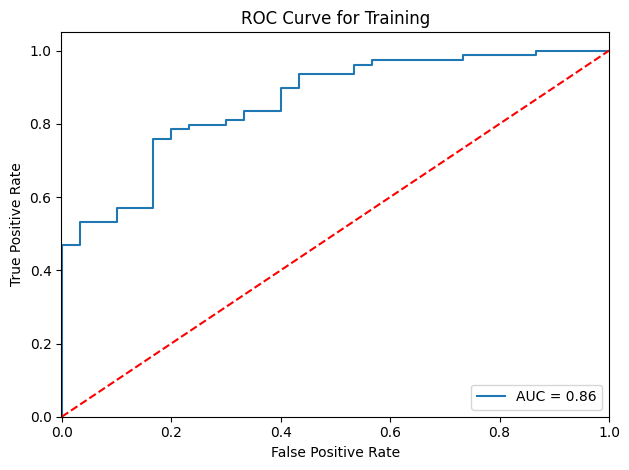

In [58]:
y_pred = model3.predict(Xxf_train.drop(columns=col_to_drop))

# calculate AUC and plot ROC curve
logit_roc_auc = roc_auc_score(y_train, y_pred)
fpr, tpr, thresholds = roc_curve(y_train,y_pred)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f'AUC = {logit_roc_auc:.2f}')
ax.plot([0,1], [0,1], 'r--')
ax.set_xlim([-0.001, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Training')
ax.legend(loc='lower right')
fig.tight_layout()

# odds ratio
print(pd.DataFrame(np.exp(model3.params),columns=['Odds Ratio']).round(2))
print()

# accuracy, auc
print('----------------')
print('Training Dataset')
print('----------------')
print(f'Accuracy: {classification_report(y_train, np.round(y_pred), output_dict=True)["accuracy"]:.2f}')
print(f'     AUC: {logit_roc_auc:.2f}')
print()



# classification report
print('Classification Report')
print('---------------------')
print(classification_report(y_train,np.round(y_pred)))
print()
# confusion matrix
cm = confusion_matrix(y_train, np.round(y_pred))
print('Confusion Matrix')
print('----------------')
print(cm)

_3.b. For the “best” model, using the test dataset, create a ROC curve plot and calculate the accuracy, AUC, classification report and confusion matrix. The odds ratio does not need to be recalculated._

------------
Test Dataset
------------
Accuracy: 0.81
     AUC: 0.77

Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.82      0.56      0.67        16
           1       0.81      0.94      0.87        32

    accuracy                           0.81        48
   macro avg       0.81      0.75      0.77        48
weighted avg       0.81      0.81      0.80        48


Confusion Matrix
----------------
[[ 9  7]
 [ 2 30]]


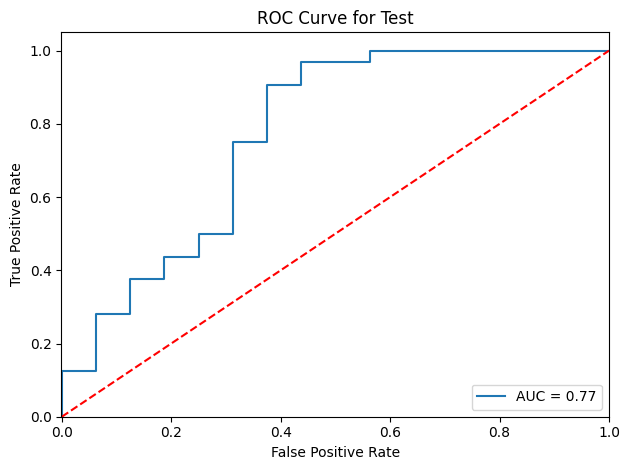

In [54]:
y_pred = model3.predict(Xxf_test.drop(columns=col_to_drop))
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test,y_pred)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f'AUC = {logit_roc_auc:.2f}')
ax.plot([0,1], [0,1], 'r--')
ax.set_xlim([-0.001, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Test')
ax.legend(loc='lower right')
fig.tight_layout()

# accuracy, auc
print('------------')
print('Test Dataset')
print('------------')
print(f'Accuracy: {classification_report(y_test, np.round(y_pred), output_dict=True)["accuracy"]:.2f}')
print(f'     AUC: {logit_roc_auc:.2f}')
print()
# classification report
print('Classification Report')
print('---------------------')
print(classification_report(y_test,np.round(y_pred)))
print()
# confusion matrix
cm = confusion_matrix(y_test, np.round(y_pred))
print('Confusion Matrix')
print('----------------')
print(cm)

# Business/Mission Understanding

_4. Discussion_ 

   _a. Include a text block related to Business/Mission Understanding:_
   
   _iv. Review the “Binary Classification metric summary” file from the week 2 Canvas page._  
    _v. Mention what the majority class is (either passing or failing the test), the % of datapoints in the majority class and whether or not the dataset is balanced._  
    _vi. Discuss the penalty (if any) associated with a False Negative and False Positive. Mention if the penalty is equal or unequal._  
    _vii. Discuss the metrics (accuracy/f1/etc) that would be most appropriate for this problem based on the balance & penalties_

In this dataset the majority class is passing the fitness assessment, which contains 70.7% of the datapoints. While this class is over twice the size of the minority class, it can still be considered a balanced dataset.  

Assuming the model would be used to predict whether an Airman would pass the fitness assessment lets consider the penalties for false negative and false positives. A false negative is the model predicts a test failure but the Airman passes, and a false positive is a predicted passing test but the Airman fails. Incorrectly predicting a failure still has a positive outcome of the Airman passing the test. In this case the false positive has a higher penalty. The model predicting false would likely lead to more training, either personally motivated or commander directed, which would increase the probability of passing the test. In the case of a false positive, Airman that could use the extra training do not get it and then face the consequence of failing the fitness test. An argument could be made that commander directed PT as a result of a false model prediction is a high penalty. However, failing the fitness assessment is worse for the Airman's career and the unit's readiness, so the higher penalty is incorrectly predicting a passing test.  

The most appropriate metric to use would be the precision for the passing the test because the dataset is balanced and the penalty for Type I errors, or false positives, is higher. Higher precision correlates to decreasing false positives.

_4.b. Include a text block relating to the best model:_

   _viii. Discuss the most important 2-3 input variables, based on their z or p test scores._  
    _ix. Include a discussion of the “most appropriate” performance metrics from part 2.f.  Based on the train & test dataset performance, mention if the model has overfit the data_  
    _x. Write in a formal writing style based on the Appendix B guidance, with the exception that references and citations are not required._

The best model contained four parameters: Sleep_score, survey_FitSat, BMI, and Gender_M.   Their _z_ scores and _p_ values are shown in the table below in order of importance.

|  Parameter    |_z_ score|_p_ value|
|--------------:|--------:|------:|
|      Gender_M |   4.570 | 0.000 |
| survey_FitSat |   3.431 | 0.001 |
|           BMI |  -3.000 | 0.003 |
|   Sleep_score |  -2.890 | 0.004 |

The top two are the gender and the FitSat survey. Both coefficients for these variables are positive which indicates when the member is male there is a higher probability of passing the test vs when female and the higher the FitSat survey score the more likely the passing score. These assume all other variables as constant respectively.  

Considering the most appropriate metric to be the precision, model 2 did slightly better than model 3 on the test data. However, there was only a difference of one false positive between the two models. Model 3 also had a higher recall and accuracy, and was a simpler model overall. For model 3 the performance for almost all metrics (accuracy, precision, recall, f1) is very similar between the training data and the test data, which indicates the model has not overfit the data.


---

### Take closer look at the variables in the best model

<Axes: xlabel='Gender_M', ylabel='Count'>

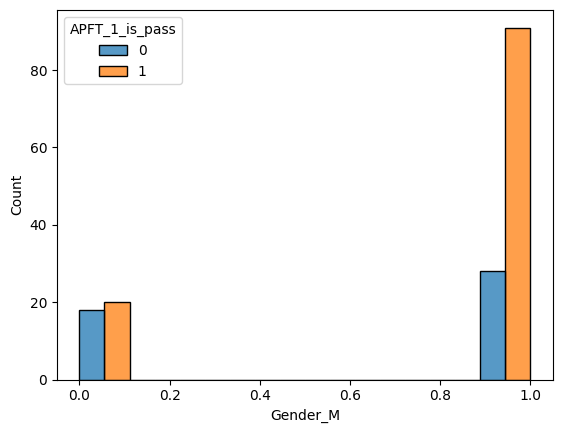

In [98]:
sns.histplot(data=df_ohe, hue=target, x='Gender_M', multiple='dodge')

<Axes: xlabel='survey_FitSat', ylabel='Percent'>

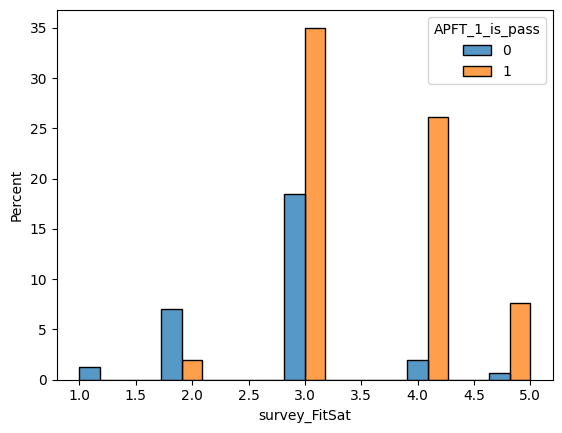

In [96]:
sns.histplot(data=df_ohe, hue=target, x='survey_FitSat', stat='percent', multiple='dodge')

<Axes: xlabel='BMI', ylabel='Percent'>

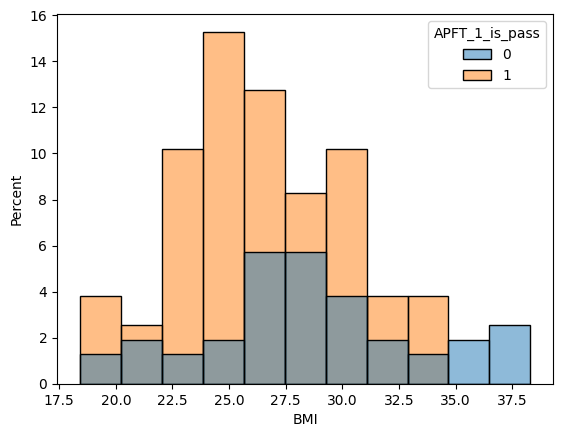

In [92]:
sns.histplot(data=df_ohe, x='BMI', hue=target, stat='percent')

<Axes: xlabel='Sleep_score', ylabel='Percent'>

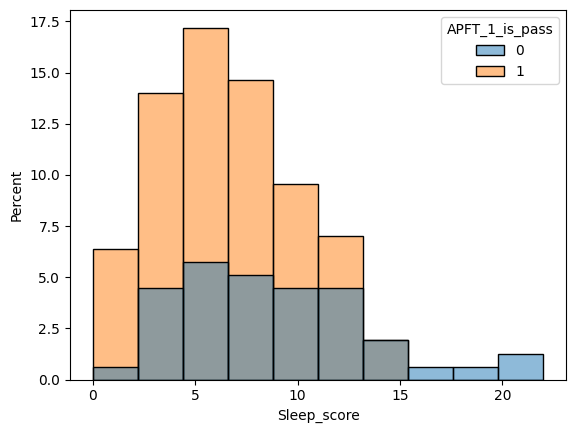

In [95]:
sns.histplot(data=df_ohe, x='Sleep_score', hue=target, stat='percent')